Web Scraping with Beautiful Soup
PS 452: Text As Data
Fall 2014
Department of Political Science, Stanford University
Adapted from Rebecca Weiss's VAM tutorial by Frances Zlotnick

This tutorial will provide a very basic introduction to using the Beautiful Soup package to scrape text data from the web. This assumes that you already have the necessary packages installed.

HTML and the DOM

The general idea behind web scraping is to retrieve data that exists on a website, and convert it into a format that is usable for analysis. Webpages are rendered by the brower from HTML and CSS code, but much of the information included in the HTML underlying any website is not interesting to us.
We begin by reading in the source code for a given web page and creating a Beautiful Soup object with the BeautifulSoup function.

In [9]:
from bs4 import BeautifulSoup
import requests


In [12]:
r = requests.get('http://www.aflcio.org/Legislation-and-Politics/Legislative-Alerts')
soup = BeautifulSoup(r.text, 'html.parser')
print (type(soup))

<class 'bs4.BeautifulSoup'>


The soup object contains all of the HTML in the original document.

In [13]:
print (soup.prettify()[0:1000])

<!DOCTYPE html>
<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# " xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:product="http://ogp.me/ns/product#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:video="http://ogp.me/ns/video#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   window.NREUM||(NREUM={}),__nr_require=function(e,n,t){function r(t){if(!n[t]){var o=n[t]={exports:{}};e[t][0].call(o.exports,function(n){var o=e[t][1][n];return r(o||n)},o,o.exports)}return n[t].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<t.length;o++)r(t[o]);return r}({1:[functi

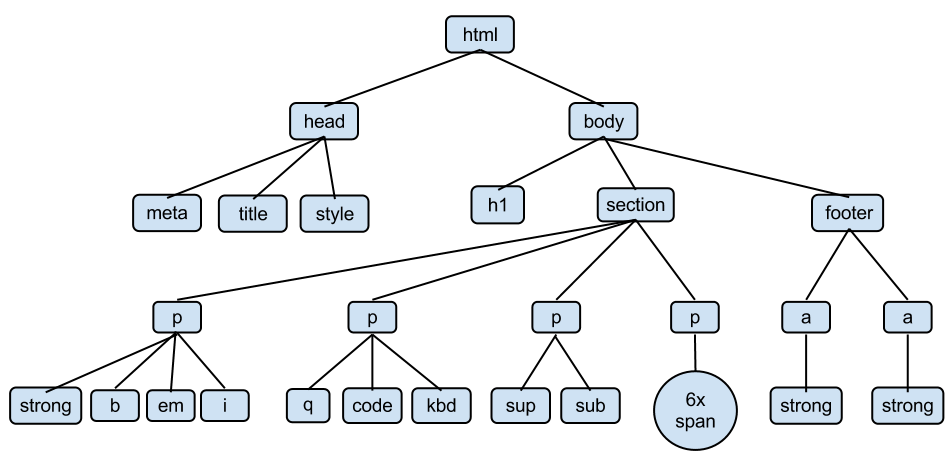

In [14]:
from IPython.display import Image
Image('http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png')

Most modern browsers have a parser that reads in the HTML document, parses it into a DOM (Document Object Model) structure, and then renders the DOM structure.
Much like HTTP, the DOM is an agreed-upon standard.
The DOM is much more than what I've described, but for our purposes, what is most important to understand is that the text is only one part of an HTML element, and we need to select it explicitly.

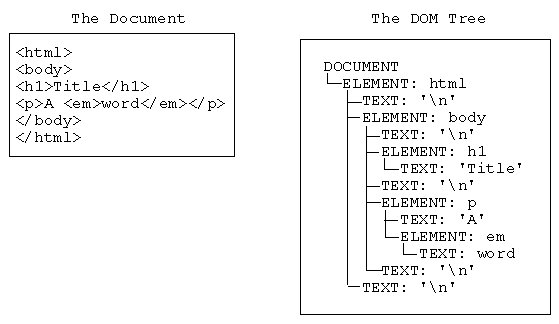

In [15]:
Image('http://www.cs.toronto.edu/~shiva/cscb07/img/dom/treeStructure.png')

Parsing HTML

I study interest group political activity, and I'd like to know what issues organized labor was active on this year. Fortunately, the largest American labor federation has a website where they document the letters* that the national organization has sent to federal legislators. This is the page we loaded in above.
*Some things to always think about, regardless of your source: Who created this website? Do we think this is likely to be a complete list? Might this organization have some reason to selectively post information?

In [16]:
from IPython.display import HTML
HTML('<iframe src=http://www.aflcio.org/Legislation-and-Politics/Legislative-Alerts width=700 height=500></iframe>')

Our goal here is to get the name of each item in this list, the URL that it links to, and the associated date. This sounds easy, but there is alot of junk to wade through to find what we want. By looking at the source code, I found that all of the items I am interested in are in a single div element of class "legisalerts_listing", and that each individual item is a member of class "ec_statements". Here is what the first few look like in HTML.

In [17]:
print (soup.prettify()[28700:30500])

2017-10-16T16:10:53-0400">
                  October 16, 2017
                 </time>
                </div>
               </a>
               <div>
               </div>
              </div>
             </div>
             <div class="block block-content col-12 col-lg-4">
              <div class="content-details ">
               <a class="b-inner" href="/about/advocacy/legislative-alerts/letter-concerning-jones-act-and-puerto-rico">
                <div class="b-text">
                 <h5 class="content-type">
                  Legislative Alert
                 </h5>
                 <h2 class="content-title">
                  <span>
                   Letter Concerning the Jones Act and Puerto Rico
                  </span>
                 </h2>
                 <time datetime="2017-10-13T10:50:08-0400">
                  October 13, 2017
                 </time>
                </div>
               </a>
               <div>
               </div>
              </div>
      

I can use the heirarchical nature of HTML structure to grab precisely the content that I am interested in. I will grab all of the elements that are within div tags and are also members of class "ec_statements."

In [22]:
letters = soup.find_all("div", class_="content-details")

This returns a collection of tag objects. This is not one of the normal python collections covered in the other tutorials, it is an object specific to the Beautiful Soup library. It can be iterated over, but most other standard methods won't work on it. We'll have to do some preprocessing to get out the content that we want.

In [23]:
print (type(letters))

<class 'bs4.element.ResultSet'>


By examining one of the elements in this collection, we can see that the information we want inside these objects, but we'll need to use more of Beautiful Soup's functionality and know something about HTML strucure to access them.

In [40]:
print (letters[0])

<div class="content-details ">
<a class="b-inner" href="/about/advocacy/legislative-alerts/letter-opposing-bill-would-slash-support-health-programs-benefit">
<div class="b-text">
<h5 class="content-type">Legislative Alert</h5>
<h2 class="content-title"><span>Letter Opposing Bill That Would Slash Support for Health Programs That Benefit Working Families</span>
</h2>
<time datetime="2017-11-03T15:57:07-0400">November 3, 2017</time>
</div>
</a>
<div></div>
</div>


Recall that we want 3 things: the text of the item as it appears on the website, the URL that is linked to (so we can scrape and analyze it later), and the date the letter was sent.
First we should consider how we are going to store this data. Since we want to maintain the association between the 3 things from each observation. A natural way to store this is as a nested dict. Dict keys must be unique, and some of our items have the same associated date, so we'll have to use one of the other items. We'll use the name.
Visible text is always placed between tags. On the rendered page, the name we want is an active link, but we can get just the associated text by using the get_text method on the a tags. You can also use contents, which returns a list instead of a string.
We'll go through all of the items in our letters collection, and for each one, pull out the name and make it a key in our dict. The value will be another dict, but we haven't yet found the contents for the other items yet so we'll just create assign an empty dict object.

In [41]:
lobbying = {}
for element in letters:
    lobbying[element.a.get_text()] = {}
    

Now we want to add to our inner dictionary by the linked URL.
In HTML, links are always enclosed in a tags as the href attribute. We can use this fact to easily pull out the links. But if we look at the URLs, we'll find that they are incomplete. Like many websites, this site uses relative paths.

In [42]:
letters[0].a["href"]

'/about/advocacy/legislative-alerts/letter-opposing-bill-would-slash-support-health-programs-benefit'

If we want to visit these links later we'll need the complete path, so we will add in a prefix to complete these paths.

In [43]:
prefix = "www.aflcio.org"

Now we'll go through our letters collection again, and add a link key to our lobbying dictionaries.

In [44]:
for element in letters:
    lobbying[element.a.get_text()]["link"] = prefix + element.a["href"]

Now we'll do the same thing with the date. Note that all of the dates are found within div tags with id "legalert_date". We can use this structure to grab the date information just as we did the link text. We know there is only one of these per item so we can use find instead of find_all.

In [65]:
print(letters[0].h2.span.text)

Letter Opposing Bill That Would Slash Support for Health Programs That Benefit Working Families


In [66]:
for element in letters:
    heading = element.h2.span.text
    lobbying[element.a.get_text()]["heading"] = heading

In [67]:
letters[0].find("time")

<time datetime="2017-11-03T15:57:07-0400">November 3, 2017</time>

In [70]:
letters[0].find("time").get_text()

'November 3, 2017'

Now we'll add it into our lobbying dictionary. We can see above that we only want the text between the tags, so we'll pull that out before adding it into the dictionary.

In [71]:
for element in letters:
    date = element.find("time").get_text()
    lobbying[element.a.get_text()]["date"] = date

In [74]:
for item in lobbying.keys():
    print ("Heading: " + lobbying[item]["heading"] + "\n" + "link: " + lobbying[item]["link"] + "\n" + "date: " + lobbying[item]["date"] + "\n\n" )

Heading: Letter Opposing Bill That Would Slash Support for Health Programs That Benefit Working Families
link: www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-bill-would-slash-support-health-programs-benefit
date: November 3, 2017


Heading: Letter Opposing Nomination of Mark S. Norris to U.S. District Court
link: www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-nomination-mark-s-norris-us-district-court
date: November 3, 2017


Heading: Letter Opposing Section of Bill That Would Eliminate Important Buy American Requirements for Defense Procurement
link: www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-section-bill-would-eliminate-important-buy
date: October 31, 2017


Heading: Letter Opposing Legislation That Would Advance Flawed Immigration Enforcement Methods
link: www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-legislation-would-advance-flawed-immigration
date: October 31, 2017


Heading: Letter Opposing Bill That Wo

Writing to File

Now we can save it for later use. Typically you will use the DictWriter class of the csv module to write nested dictionaries, however if you want to write the keys as well as the values, you can't use that package. Because we want our keys in this case, we'll use the more general version.

In [75]:
import os, csv
#os.chdir("/Users/franceszlotnick/Dropbox/TextAsData/Sections/tutorials/")

with open("lobbying.csv", "w") as toWrite:
    writer = csv.writer(toWrite, delimiter=",")
    writer.writerow(["heading", "link", "date"])
    for a in lobbying.keys():
        writer.writerow([lobbying[a]["heading"], lobbying[a]["link"], lobbying[a]["date"]])

A better format for recording nested dictionaries is JSON (Java Script Object Notation). It is trivially easy to write this type of structure with nested dictionaries in python. This is a format you should get comfortable with, because this is how most data from APIs is provided. But we'll save that for another tutorial!

In [76]:
import json

with open("lobbying.json", "w") as writeJSON:
    json.dump(lobbying, writeJSON)

In [77]:
# conventional way to import pandas
import pandas as pd

In [85]:
# read a dataset of movie reviewers (modifying the default parameter values for read_table)
#cols = ['heading', 'link', 'date']
news = pd.read_csv('lobbying.csv')

In [86]:
news

heading  \
0   Letter Opposing Bill That Would Slash Support ...   
1   Letter Opposing Nomination of Mark S. Norris t...   
2   Letter Opposing Section of Bill That Would Eli...   
3   Letter Opposing Legislation That Would Advance...   
4   Letter Opposing Bill That Would Weaken Protect...   
5         Letter to Senate Opposing Budget Resolution   
6   Letter Opposing Michael Dourson's Appointment ...   
7     Letter Concerning the Jones Act and Puerto Rico   
8      Senate Letter Opposing FY 2018 Budget Proposal   
9       House Letter Opposing FY 2018 Budget Proposal   
10  Letter Opposing Bill That Would Weaken Worker ...   
11  Letter Opposing Legislation That Would Weaken ...   
12         Letter in Support of the DREAM Act of 2017   
13  Letter Concerning Nomination of Peter Robb as ...   
14  Letter Opposing NLRB Nomination of William Ema...   
15  Letter Opposing the Nomination of Justice Alli...   
16      Letter Opposing the Nomination of Thomas Farr   
17  Letter Opposing Amendments to the National Def...   

                                                 link                date  
0   www.aflcio.org/about/advocacy/legislative-aler...    November 3, 2017  
1   www.aflcio.org/about/advocacy/legislative-aler...    November 3, 2017  
2   www.aflcio.org/about/advocacy/legislative-aler...    October 31, 2017  
3   www.aflcio.org/about/advocacy/legislative-aler...    October 31, 2017  
4   www.aflcio.org/about/advocacy/legislative-aler...    October 31, 2017  
5   www.aflcio.org/about/advocacy/legislative-aler...    October 30, 2017  
6   www.aflcio.org/about/advocacy/legislative-aler...    October 16, 2017  
7   www.aflcio.org/about/advocacy/legislative-aler...    October 13, 2017  
8   www.aflcio.org/about/advocacy/legislative-aler...     October 5, 2017  
9   www.aflcio.org/about/advocacy/legislative-aler...     October 4, 2017  
10  www.aflcio.org/about/advocacy/legislative-aler...     October 3, 2017  
11  www.aflcio.org/about/advocacy/legislative-aler...     October 3, 2017  
12  www.aflcio.org/about/advocacy/legislative-aler...     October 3, 2017  
13  www.aflcio.org/about/advocacy/legislative-aler...     October 2, 2017  
14  www.aflcio.org/about/advocacy/legislative-aler...  September 25, 2017  
15  www.aflcio.org/about/advocacy/legislative-aler...  September 20, 2017  
16  www.aflcio.org/about/advocacy/legislative-aler...  September 20, 2017  
17  www.aflcio.org/about/advocacy/legislative-aler...  September 14, 2017

In [89]:
news.shape

(18, 3)

In [90]:
news.dtypes

heading    object
link       object
date       object
dtype: object

In [92]:
news.describe()

heading  \
count                                              18   
unique                                             18   
top     House Letter Opposing FY 2018 Budget Proposal   
freq                                                1   

                                                     link             date  
count                                                  18               18  
unique                                                 18               12  
top     www.aflcio.org/about/advocacy/legislative-aler...  October 3, 2017  
freq                                                    1                3